## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

###Отчет.

Сначала в качестве backbone для модели я взял EfficientNet B5 из torchvision.models, сделал finetune для последнего линейного слоя в полносвязной части модели. Обучал модель в течение 20 эпох, почему-то получил всего 70% accuracy.

Затем, я разбил тренировочные даннные на тренировочную и валидационную выборки, вместо EfficientNet B5 я попробовал взять VGG19 с батч нормализацией. Далее обучал модель в течение 20 эпох, получил accuracy на валидации 86%.
Далее, в качестве backbone я использовал Resnet-152. После обучения в течение 15 эпох получил 90.8% accuracy на валидации. При этом по построенной кривой обучения, я заметил, что минимум функции потерь и максимум accuracy на валидационных данных наблюддается после 5 эпохи. Поэтому я попробовал обучать модель 5 эпох, но результат ухудшился: 88.4%.

In [1]:
# Your experiments here
from torchvision.datasets import ImageFolder
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
from torchvision import transforms, models, datasets
import torch

image_std = [0.229, 0.224, 0.225]
image_mean = [0.485, 0.456, 0.406]
data_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(image_mean, image_std),
     transforms.Resize((224, 224)),
     transforms.RandomRotation(degrees = 20),
     transforms.RandomHorizontalFlip()
     ]
     )
data_dir = '/content/drive/My Drive/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms)
                  for x in ['train']}

BATCH_SIZE = 16
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=4)
              for x in ['train']}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [3]:
train_size = int(0.8 * len(image_datasets['train']))
test_size = len(image_datasets['train']) - train_size
train_split, val_split= torch.utils.data.random_split(image_datasets['train'], [train_size, test_size])
train_loader, val_loader = torch.utils.data.DataLoader(train_split, batch_size=16, num_workers=4), torch.utils.data.DataLoader(val_split, batch_size=16, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [4]:
print(len(train_loader))
print(len(val_loader))

359
90


In [5]:
class_to_idx = image_datasets['train'].class_to_idx

In [14]:
from torchvision.models import resnet152
import torch
from torch.optim import Adam
import torch.nn as nn

model = resnet152(pretrained=True)
print(model.fc)

Linear(in_features=2048, out_features=1000, bias=True)


In [15]:
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(in_features=2048, out_features=50)
for param in model.fc.parameters():
    param.requires_grad = True
print(model.fc)    

Linear(in_features=2048, out_features=50, bias=True)


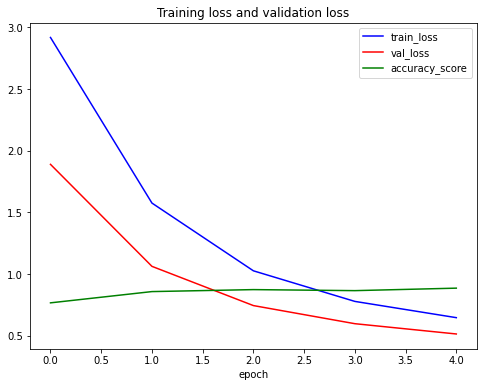

Current train loss: 0.647355
Current val loss: 0.515144
Current accuracy: 0.886490


In [16]:
import matplotlib.pyplot as plt
from IPython import display

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_func = nn.CrossEntropyLoss()

BATCH_SIZE = 16
# Your experiments, training and validation loops here
train_loss = []
val_loss = []
accuracy_scores = []
total = 0
correct = 0
for i in range(1, 6):
    model.train()
    running_loss = 0.0
    for j, batch in enumerate(train_loader):
        data, target = batch  
        data, target = data.to(device), target.to(device)
        opt.zero_grad()
        output = model(data)
        predictions = output.argmax(dim=1, keepdim=True).squeeze()
        loss = loss_func(output, target)
        
        loss.backward()
        opt.step()
        running_loss += loss.item()

    train_loss.append(running_loss / len(train_loader))
    model.eval()
    cur_loss = 0.0
    correct = 0
    total = 0
    for data in val_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs.data, dim=1)
        cur_loss += loss_func(outputs, labels)
        total += labels.size(0)
        correct += (predictions == labels).sum().item()
    accuracy = correct / total
    accuracy_scores.append(accuracy)
        
    val_loss.append(cur_loss / len(val_loader))
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss and validation loss")
    plt.xlabel("epoch")
    plt.plot(train_loss, 'b', label='train_loss')
    plt.plot(val_loss, 'r', label='val_loss')
    plt.plot(accuracy_scores, color = 'green', label = 'accuracy_score')
    plt.legend()
    plt.show()
    
    print('Current train loss: %f' % (running_loss / len(train_loader)))   
    print('Current val loss: %f' % (cur_loss / len(val_loader)))
    print('Current accuracy: %f' % accuracy)

In [17]:
total = 0
correct = 0
model.eval()
#model = model.to(device)
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs.data, dim=1)
        total += labels.size(0)
        correct += (predictions == labels).sum().item()

print('Accuracy == {} %'.format(100 * correct / total))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy == 88.44011142061281 %


In [32]:
print(len(train_loader))

359


In [33]:
from PIL import Image

test_data = list()
test_data_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(image_mean, image_std),
     transforms.Resize((224, 224))])

path = '/content/drive/My Drive/data/test/'
for i in range(1503):
    image_path = path + str(i) + '.jpeg'
    image_name = str(i) + '.jpeg'
    image = Image.open(image_path)
    image = test_data_transforms(image)
    test_data.append(image)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=4)    

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [34]:
data_to_save = {'file_name' : []}
file_names = [str(i) + '.jpeg' for i in range(1503)]
data_to_save['file_name'] = file_names

In [35]:
import pandas as pd

model.eval()
data_to_save['predicted_class'] = []
with torch.no_grad():
    for data in test_loader:
        images = data.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs.data, dim=1)
        data_to_save['predicted_class'].extend(predictions.tolist())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [36]:
idx_to_class = dict(list(zip(list(class_to_idx.values()), list(map(int, list(class_to_idx.keys()))))))
idx_to_class

{0: 0,
 1: 1,
 2: 10,
 3: 11,
 4: 12,
 5: 13,
 6: 14,
 7: 15,
 8: 16,
 9: 17,
 10: 18,
 11: 19,
 12: 2,
 13: 20,
 14: 21,
 15: 22,
 16: 23,
 17: 24,
 18: 25,
 19: 26,
 20: 27,
 21: 28,
 22: 29,
 23: 3,
 24: 30,
 25: 31,
 26: 32,
 27: 33,
 28: 34,
 29: 35,
 30: 36,
 31: 37,
 32: 38,
 33: 39,
 34: 4,
 35: 40,
 36: 41,
 37: 42,
 38: 43,
 39: 44,
 40: 45,
 41: 46,
 42: 47,
 43: 48,
 44: 49,
 45: 5,
 46: 6,
 47: 7,
 48: 8,
 49: 9}

In [37]:
for i in range(len(data_to_save['predicted_class'])):
  data_to_save['predicted_class'][i] = idx_to_class[data_to_save['predicted_class'][i]]
print(data_to_save)  

{'file_name': ['0.jpeg', '1.jpeg', '2.jpeg', '3.jpeg', '4.jpeg', '5.jpeg', '6.jpeg', '7.jpeg', '8.jpeg', '9.jpeg', '10.jpeg', '11.jpeg', '12.jpeg', '13.jpeg', '14.jpeg', '15.jpeg', '16.jpeg', '17.jpeg', '18.jpeg', '19.jpeg', '20.jpeg', '21.jpeg', '22.jpeg', '23.jpeg', '24.jpeg', '25.jpeg', '26.jpeg', '27.jpeg', '28.jpeg', '29.jpeg', '30.jpeg', '31.jpeg', '32.jpeg', '33.jpeg', '34.jpeg', '35.jpeg', '36.jpeg', '37.jpeg', '38.jpeg', '39.jpeg', '40.jpeg', '41.jpeg', '42.jpeg', '43.jpeg', '44.jpeg', '45.jpeg', '46.jpeg', '47.jpeg', '48.jpeg', '49.jpeg', '50.jpeg', '51.jpeg', '52.jpeg', '53.jpeg', '54.jpeg', '55.jpeg', '56.jpeg', '57.jpeg', '58.jpeg', '59.jpeg', '60.jpeg', '61.jpeg', '62.jpeg', '63.jpeg', '64.jpeg', '65.jpeg', '66.jpeg', '67.jpeg', '68.jpeg', '69.jpeg', '70.jpeg', '71.jpeg', '72.jpeg', '73.jpeg', '74.jpeg', '75.jpeg', '76.jpeg', '77.jpeg', '78.jpeg', '79.jpeg', '80.jpeg', '81.jpeg', '82.jpeg', '83.jpeg', '84.jpeg', '85.jpeg', '86.jpeg', '87.jpeg', '88.jpeg', '89.jpeg', '90.j

In [38]:
import numpy as np

data_to_save_pd = pd.DataFrame(data_to_save)
data_to_save_np = data_to_save_pd[:].values
df = pd.DataFrame(data=data_to_save_np)
df.to_csv('predictions.csv', index=False, header=False)